Data sample:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_wors

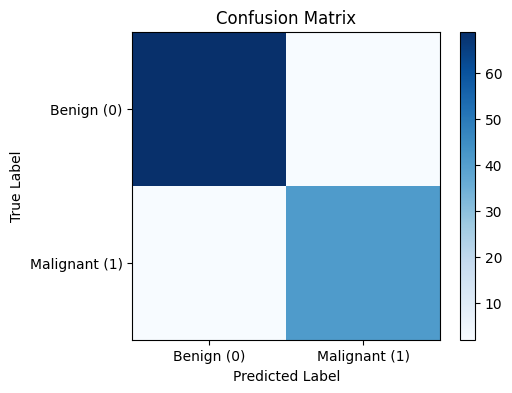

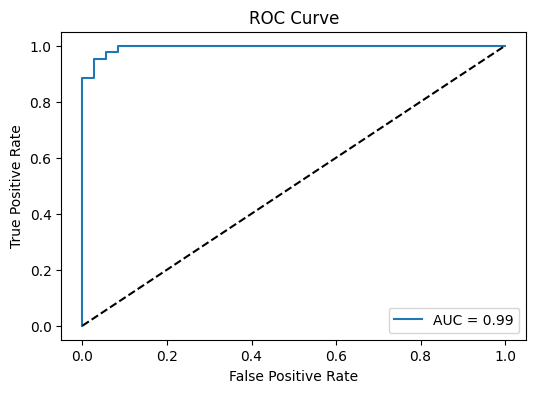


Model saved to model.pth
Model loaded and set to evaluation mode.

Hyperparameter Tuning:
LR: 0.001 => Test Accuracy: 0.6140
LR: 0.005 => Test Accuracy: 0.9561
LR: 0.01 => Test Accuracy: 0.9649
LR: 0.05 => Test Accuracy: 0.9825
LR: 0.1 => Test Accuracy: 0.9825

Best Learning Rate: 0.05 (Accuracy: 0.9825)


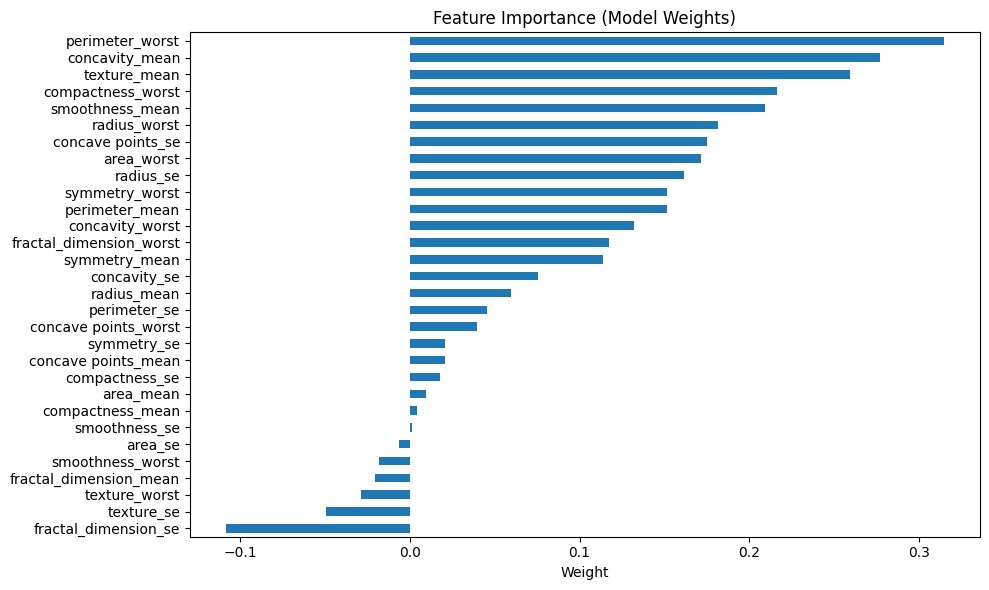

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# =============================================================================
# Step 1: Data Loading and Preprocessing
# =============================================================================
data = pd.read_csv('data.csv')

# Display the first few rows to inspect the data
print("Data sample:")
print(data.head())

# Drop unnecessary columns
data = data.drop(columns=["id", "Unnamed: 32"], errors='ignore')

# Encode diagnosis: M = 1, B = 0
data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0})

# Feature matrix and target vector
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# =============================================================================
# Step 2: Logistic Regression Model
# =============================================================================
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)

# =============================================================================
# Step 3: Model Training
# =============================================================================
num_epochs = 100
learning_rate = 0.01

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        predicted = (outputs >= 0.5).float()
        acc = accuracy_score(y_train_tensor.detach().numpy(), predicted.detach().numpy())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {acc:.4f}')

# =============================================================================
# Step 4: Evaluation
# =============================================================================
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predicted = (test_outputs >= 0.5).float()
    test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predicted.numpy())
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

cm = confusion_matrix(y_test_tensor.numpy(), test_predicted.numpy())
print("Confusion Matrix:")
print(cm)

# =============================================================================
# Step 5: Visualization
# =============================================================================
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign (0)', 'Malignant (1)'])
plt.yticks(tick_marks, ['Benign (0)', 'Malignant (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_tensor.numpy(), test_outputs.numpy())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# =============================================================================
# Step 6: Save and Load Model
# =============================================================================
model_path = 'model.pth'
torch.save(model.state_dict(), model_path)
print(f"\nModel saved to {model_path}")

loaded_model = LogisticRegressionModel(input_dim)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("Model loaded and set to evaluation mode.")

# =============================================================================
# Step 7: Hyperparameter Tuning
# =============================================================================
def train_model_with_lr(lr):
    temp_model = LogisticRegressionModel(input_dim)
    temp_optimizer = optim.SGD(temp_model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        temp_model.train()
        temp_optimizer.zero_grad()
        outputs = temp_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        temp_optimizer.step()
    temp_model.eval()
    with torch.no_grad():
        test_outputs = temp_model(X_test_tensor)
        test_predicted = (test_outputs >= 0.5).float()
        acc = accuracy_score(y_test_tensor.numpy(), test_predicted.numpy())
    return acc

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
tuning_results = {}

print("\nHyperparameter Tuning:")
for lr in learning_rates:
    acc = train_model_with_lr(lr)
    tuning_results[lr] = acc
    print(f"LR: {lr} => Test Accuracy: {acc:.4f}")

best_lr = max(tuning_results, key=tuning_results.get)
print(f"\nBest Learning Rate: {best_lr} (Accuracy: {tuning_results[best_lr]:.4f})")

# =============================================================================
# Step 8: Feature Importance
# =============================================================================
weights = model.linear.weight.detach().numpy().flatten()
feature_names = data.drop(columns=["diagnosis"]).columns

# Plot feature importance
importance = pd.Series(weights, index=feature_names).sort_values()

plt.figure(figsize=(10, 6))
importance.plot(kind="barh")
plt.title("Feature Importance (Model Weights)")
plt.xlabel("Weight")
plt.tight_layout()
plt.show()
